# Ejemplo completo

Este cuaderno contiene los pasos necesarios para realizar la segmentación y clasificación de los códigos de barras en una imagen. Para ello, se utilizará la librería OpenCV en Python.


### Importar librerías necesarias


In [1612]:
import os
from IPython.display import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Cargar y mostrar imagen


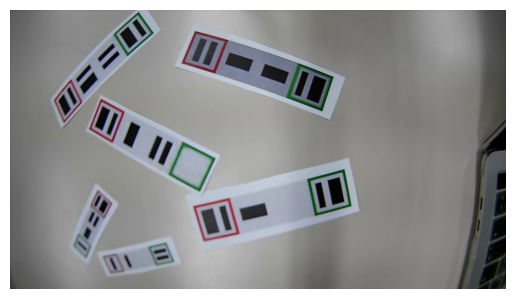

In [1613]:
# Load the image
image = cv2.imread("img/mix_G1_64.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

## Preprocesamiento de la imagen.

El preprocesamiento de la imagen va a consistir en la reducción de ruido utilizando un filtro gaussiano de kernel 7x7.


In [1614]:
def gaussian_blur(image, kernel_size):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)# 0 is the standard deviation

# Apply Gaussian blur
kernel_size = 7
image_blur = gaussian_blur(image, kernel_size)

## Segmentación de la imagen

Para segmentar los posibles códigos de la imagen se va a utilizar los colores de la imagen. Se va a realizar una segmentación por color, para ello se va a convertir la imagen a un espacio de color HSV y se va a segmentar por el color rojo y verde, ya que los códigos de barras empiezan y terminan con estos colores.


### 1. Convertir la imagen a HSV.


In [1615]:
# Convert the image to grayscale and hsv
gray_image = cv2.cvtColor(image_blur, cv2.COLOR_RGB2GRAY)
hsv_image = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)

### 2. Extraer las mascaras de los colores rojo y verde.

Para extraer las mascaras de los colores rojo y verde se va a utilizar la función `cv2.inRange`.
Una vez obtenidas las mascaras se va a realizar un cierre para unir las partes de los códigos que estén separadas, y una dilatación para unir las partes de los códigos que estén muy juntas. Para ello se va a utilizar la función `cv2.morphologyEx` y `cv2.dilate`.


In [1616]:
def close_dilate_mask(mask):
    # Apply close the mask
    kernel = np.ones((7,7), np.uint16)   
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Dilate the mask
    kernel = np.ones((5,5), np.uint16)
    mask_closed = cv2.dilate(mask_closed, kernel, iterations=1)
    return mask_closed

def get_red_mask(hsv_image):
    # H = 120, S = 20, V = 0, H1 = 179, S1 = 255, V1 = 255
    lower_red = np.array([125, 20, 0])
    upper_red = np.array([179, 255, 255])
    mask_red = cv2.inRange(hsv_image, lower_red, upper_red)
    mask_red = close_dilate_mask(mask_red)
    return mask_red

def get_green_mask(hsv_image):
    # H = 50, S = 40, V = 0, H1 = 110, S1 = 255, V1 = 160
    lower_green = np.array([50, 40, 0])
    upper_green = np.array([110, 255, 160])
    mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_green = close_dilate_mask(mask_green)
    return mask_green

mask_red = get_red_mask(hsv_image)
mask_green = get_green_mask(hsv_image)

### 3. Aplicar la mascara a la imagen en blanco y negro.

Aplicamos la máscara verde y roja por separado a la imagen en blaco y negro de forma que podemos detectar los bordes con mayor precisión que simplemente utilizando la binarización de la máscara.


In [1617]:
def apply_mask_to_image(image, mask):
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    return segmented_image

segmented_red = apply_mask_to_image(gray_image, mask_red)
segmented_green = apply_mask_to_image(gray_image, mask_green)

### 4. Encontrar los contornos

Una vez segmentada vamos a aplicar un filtro sobel para favorecer la detección de contornos. Utilizaremos un kernel de 11x11 para aplicar el filtro a la imagen. Después haremos una binarización de modo que sea más sencillo encontrar bordes.
Una vez filtrado se buscarán los contornos potenciales de ser cuadrados. Para ello se filtrará por un area mayor a 4000px y una relación de aspecto de entre 0.5 y 1.3.


In [1618]:
def sobel_filter(image, kernel_size):
    img_sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    img_sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    img_sobel = np.sqrt(img_sobel_x**2 + img_sobel_y**2)
    img_sobel = cv2.normalize(img_sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    ret, filtered_image = cv2.threshold(img_sobel, 30, 255, cv2.THRESH_BINARY)
    return filtered_image

def find_contours(image):
    image_filter = sobel_filter(image, 11)
    contours, hierarchy = cv2.findContours(image_filter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours= []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        area = cv2.contourArea(contour)
        if area > 4000 and aspect_ratio > 0.5 and aspect_ratio < 1.3:
            filtered_contours.append(contour)
    return filtered_contours

green_contours = find_contours(segmented_green)
red_contours = find_contours(segmented_red)

print('Numero de contornos verdes = ', len(green_contours))
print('Numero de contornos rojos = ', len(red_contours))

Numero de contornos verdes =  6
Numero de contornos rojos =  6


### 5. Extraer la información de los contornos

Una vez que se han detectado los contornos, se puede extraer la información, nos interesa extraer información de las esquinas, el centro, el ancho y alto del contorno, el area, relación de aspecto, perímetro y ángulo.


In [1619]:
def extract_contour_info(contours):
    contour_info = []

    for contour in contours:
        area = round(cv2.contourArea(contour), 3)
        x, y, w, h = cv2.boundingRect(contour)
        perimeter = round(cv2.arcLength(contour, True), 3)
        # Get the real corners of the contour, could not be the same as the bounding box and could be affine
        # transformed
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int16(box)
        corners = [(corner[0], corner[1]) for corner in box]

        contour_info.append({
            'corners': corners,  # Esquinas en relación a la imagen original
            'center': (round(x + w / 2, 3), round(y + h / 2, 3)),
            'width': round(w, 3),
            'height': round(h, 3),
            'area': area,
            'aspect_ratio': round(w / h, 3) if h != 0 else None,
            'perimeter': perimeter,
            'angle': round(cv2.minAreaRect(contour)[-1], 3)
        })

    return contour_info

green_contour_info = extract_contour_info(green_contours)
red_contour_info = extract_contour_info(red_contours)


### 6. Unir los contornos rojos con los verdes

Para unir los contornos rojos con los verdes, necesitamos utilizar diferentes relaciones entre contornos.
Para ello se va a utilizar una función que recibe los contornos rojos y verdes y devuelve los contornos unidos. Para emparejar los contornos se va a utilizar la distancia euclídea entre los centros de los contornos y el angulo de los contornos. En caso de que varíos candidatos cumplan con las condiciones se seleccionará el que tenga una coincidencia de área y perímetro mayor.


In [1620]:
def match_contours(red_contours_info, green_contours_info):
    matches = []
    used_red_contours = set()
    used_green_contours = set()

    for red_contour in red_contours_info:
        # Verificar si este contorno rojo ya está emparejado
        if id(red_contour) in used_red_contours:
            continue

        best_match = None
        best_angle_match = float('inf')  # Para encontrar el mejor ángulo
        best_score = float('inf')       # Para desempatar usando área y perímetro

        for green_contour in green_contours_info:
            # Verificar si este contorno verde ya está emparejado
            if id(green_contour) in used_green_contours:
                continue
            # Calcular distancia entre centros
            center_distance = np.linalg.norm(
                np.array(red_contour['center']) - np.array(green_contour['center'])
            )
            # Descartar si la distancia excede 3.5 veces la anchura del contorno rojo
            if center_distance > 3.2 * red_contour['width']:
                continue
            # Calcular diferencia de ángulo
            angle_diff = abs(red_contour['angle'] - green_contour['angle'])
            # Descartar si la diferencia de ángulo es mayor a 10 grados
            # if angle_diff > 20:
            #     continue
            # Calcular diferencias adicionales para desempatar
            area_diff = abs(red_contour['area'] - green_contour['area'])
            perimeter_diff = abs(red_contour['perimeter'] - green_contour['perimeter'])
            # Crear puntaje de desempate
            score = area_diff + perimeter_diff
            # Actualizar el mejor match
            if angle_diff < best_angle_match or (angle_diff == best_angle_match and score < best_score):
                best_angle_match = angle_diff
                best_score = score
                best_match = green_contour
        if best_match:
            matches.append((red_contour, best_match))
            used_red_contours.add(id(red_contour))
            used_green_contours.add(id(best_match))
    return matches

# Emparejar los contornos
matched_contours = match_contours(red_contour_info, green_contour_info)


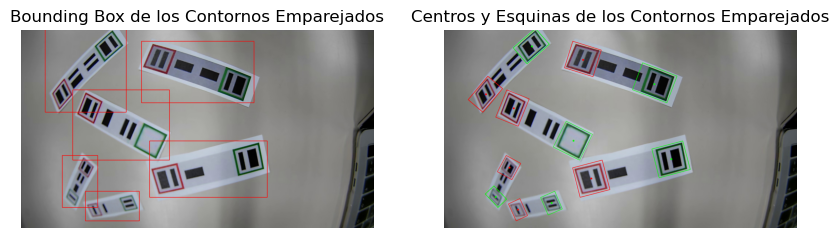

In [1621]:
# Crear una copia de la imagen original para dibujar los contornos emparejados
image_with_centers_and_corners = np.copy(image)

# Dibujar los contornos emparejados
for red_contour, green_contour in matched_contours:
    # Dibujar el centro del contorno rojo
    cv2.circle(image_with_centers_and_corners, (int(red_contour['center'][0]), int(red_contour['center'][1])), 5, (255, 0, 0), -1)
    # Dibujar las esquinas del contorno rojo
    for i in range(4):
        cv2.line(image_with_centers_and_corners, tuple(red_contour['corners'][i]), tuple(red_contour['corners'][(i + 1) % 4]), (255, 0, 0), 2)

    # Dibujar el centro del contorno verde
    cv2.circle(image_with_centers_and_corners, (int(green_contour['center'][0]), int(green_contour['center'][1])), 5, (0, 255, 0), -1)
    # Dibujar las esquinas del contorno verde
    for i in range(4):
        cv2.line(image_with_centers_and_corners, tuple(green_contour['corners'][i]), tuple(green_contour['corners'][(i + 1) % 4]), (0, 255, 0), 2) 

# Crear una copia de la imagen original para dibujar la bounding box
imagen_con_bounding_box = np.copy(image)
for red_contour, green_contour in matched_contours:
        # Obtener los puntos de los contornos
        red_points = np.array(red_contour['corners'])
        green_points = np.array(green_contour['corners'])

        # Combinar los puntos de ambos contornos
        all_points = np.vstack((red_points, green_points))

        # Calcular la bounding box que contenga todos los puntos
        x_min, y_min = np.min(all_points, axis=0)
        x_max, y_max = np.max(all_points, axis=0)

        # Dibujar la bounding box
        cv2.rectangle(imagen_con_bounding_box, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)

# Mostrar la imagen con la bounding box
plt.figure(figsize=[10, 10])
plt.subplot(121); plt.imshow(imagen_con_bounding_box); plt.axis('off'); plt.title('Bounding Box de los Contornos Emparejados'); 
plt.subplot(122); plt.imshow(image_with_centers_and_corners); plt.axis('off'); plt.title('Centros y Esquinas de los Contornos Emparejados'); 
plt.show()



### 7. Recortar los códigos para clasificarlos

Una vez que se han unido los contornos rojos con los verdes, se recortarán los códigos para clasificarlos. Para ello se recortará la imagen original con las coordenadas de los contornos unidos y rotada de forma que el código siempre quede horizontal y con el contorno rojo a la izquierda y el verde a la derecha.


In [1622]:
def cut_bounding_box(matched_contours, image):
    extracted_images = []

    for red_contour, green_contour in matched_contours:
        # Obtener los puntos de los contornos
        red_points = np.array(red_contour['corners'])
        green_points = np.array(green_contour['corners'])
        # Combinar los puntos de ambos contornos
        all_points = np.vstack((red_points, green_points))
        # Calcular la bounding box que contenga todos los puntos
        x_min, y_min = np.min(all_points, axis=0)
        x_max, y_max = np.max(all_points, axis=0)
        # Convertir los centros a tuplas de enteros
        red_center = tuple(map(int, red_contour['center']))
        # Calcular el ángulo entre los centros
        x0, y0 = red_contour['center']
        x1, y1 = green_contour['center']
        angle = np.arctan2(y1 - y0, x1 - x0) * 180 / np.pi
        # Rotar la imagen original para que la línea entre los centros sea horizontal
        M = cv2.getRotationMatrix2D(red_center, angle, 1)
        rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
        # Transformar las coordenadas de los contornos según la rotación
        ones = np.ones((red_points.shape[0], 1))
        red_points_homogeneous = np.hstack([red_points, ones])
        green_points_homogeneous = np.hstack([green_points, ones])
        transformed_red_points = (M @ red_points_homogeneous.T).T
        transformed_green_points = (M @ green_points_homogeneous.T).T
        # Combinar los puntos transformados
        transformed_all_points = np.vstack((transformed_red_points, transformed_green_points))
        # Calcular la nueva bounding box en la imagen rotada
        x_min, y_min = np.min(transformed_all_points, axis=0).astype(int)
        x_max, y_max = np.max(transformed_all_points, axis=0).astype(int)
        # Validar las coordenadas para asegurarse de que estén dentro de los límites
        h, w = rotated_image.shape[:2]
        x_min, x_max = max(0, x_min), min(w, x_max)
        y_min, y_max = max(0, y_min), min(h, y_max)
        # Verificar que las dimensiones del recorte sean válidas
        if x_min < x_max and y_min < y_max:
            cropped_image = rotated_image[y_min:y_max, x_min:x_max]

            if cropped_image.size > 0:  # Comprobar que el recorte no sea vacío
                extracted_images.append(cropped_image)
            else:
                print(f"Warning: Empty crop for contours {red_contour['center']} and {green_contour['center']}")
        else:
            print(f"Warning: Invalid crop coordinates for contours {red_contour['center']} and {green_contour['center']}")
    return extracted_images

extracted_images = cut_bounding_box(matched_contours, image)

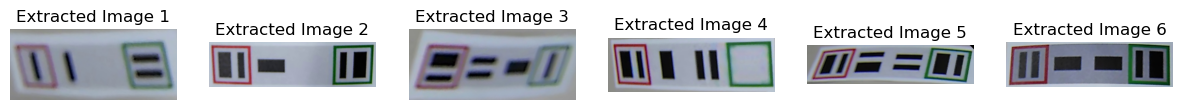

In [1623]:
plt.figure(figsize=[15, 10])
for i, img in enumerate(extracted_images):
    plt.subplot(1, len(extracted_images), i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Extracted Image {i+1}')
plt.show()


## Clasificación de los códigos

Los códigos se clasificarán estudiando los contornos de los códigos internos y estableciendo relaciones entre ellos.


### Función para binarizar la imagen


In [1624]:
def threshold_image(image, threshold = 2):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_blur_gaussian = cv2.GaussianBlur(image_gray, (11, 11), 0)
    image_threshold_gaussian = cv2.adaptiveThreshold(image_blur_gaussian, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, threshold)
    # Hacer los bordes más suaves con erosión
    kernel = np.ones((3,3), np.uint8)
    thresholded_image = cv2.erode(image_threshold_gaussian, kernel, iterations=1)
    return thresholded_image


### Función para segmentar los contornos de los códigos


In [1625]:

# Get square and rectangular contours
def segment_contours(contours, image_shape):
    square_contours = []
    rectangular_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        area_ratio = area / (image_shape[0] * image_shape[1])
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if 0.5 <= aspect_ratio <= 1.5 and area_ratio > 0.06:
            square_contours.append(contour)
        else:
            rectangular_contours.append(contour)
    return square_contours, rectangular_contours

# Function to filter contours that are inside other contours
def filter_inside_contours(contours):
    filtered_contours = []
    for contour in contours:
        parent_contour = None
        for other_contour in contours:
            if contour is not other_contour:
                # Verifica si todos los puntos están dentro del otro contorno
                if all(
                    cv2.pointPolygonTest(other_contour, (int(point[0][0]), int(point[0][1])), False) > 0
                    for point in contour
                ):
                    if parent_contour is None or cv2.contourArea(other_contour) > cv2.contourArea(parent_contour):
                        parent_contour = other_contour
        if parent_contour is None:
            filtered_contours.append(contour)
    return filtered_contours

def get_contours(thresholded_image, image):
    contours, hierarchy = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    filtered_contours= []
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        if 200 <= area <= 25000:
            # If the contour is centered close to the border, ignore it
            if x > 10 and y > 10 and x + w < image.shape[1] - 15 and y + h < image.shape[0] - 10:
                filtered_contours.append(contour)
    
    square_contours, rectangular_contours = segment_contours(filtered_contours, image.shape)
    # Filter contours that are inside others
    filtered_contours = filter_inside_contours(rectangular_contours)
    return filtered_contours

### Función para ordenar los contornos de cada segmento


In [1626]:
def order_contours(segments):
    ordered_segments = []
    for segment in segments:
        if len(segment) <= 1:
            ordered_segments.append(segment)
        elif len(segment) == 2:
            x1, y1, w1, h1 = cv2.boundingRect(segment[0])
            x2, y2, w2, h2 = cv2.boundingRect(segment[1])
            if w1 > h1 and w2 > h2:
                if y1 < y2:
                    ordered_segments.append([segment[0], segment[1]])
                else:
                    ordered_segments.append([segment[1], segment[0]])
            elif w1 < h1 and w2 < h2:
                if x1 < x2:
                    ordered_segments.append([segment[0], segment[1]])
                else:
                    ordered_segments.append([segment[1], segment[0]])
            else:
                ordered_segments.append([])
        else:
            # Retornar un segmento vacío si no se puede ordenar
            ordered_segments.append([])
    return ordered_segments

### Función para calcular la relación de area

La relación de área se define como el área del contorno dividido por el área del segmento. El area del segmento se calcula como el area de la imagen dividido por el número de segmentos.


In [1627]:
def get_area_ratio(contours, image):
    image_area = (image.shape[0] * image.shape[1]) / 4
    area_ratios = []
    for contour in contours:
        area = cv2.contourArea(contour)
        area_ratio = area / image_area
        area_ratios.append(round(area_ratio, 3))
    return area_ratios

### Función para extraer la orientación de los contornos

Utilizaremos la información de orientación para clasificar por orientación los códigos.


In [1628]:
def get_orientation(contours):
    orientations = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > h:
            orientations.append('horizontal')
        else:
            orientations.append('vertical')
    return orientations

### Función para extraer toda la información necesaria de los contornos

Esta información será utilizada para clasificar los códigos. Solo necesitaremos el número de contornos, la orientación y la relación de área, tanto entre los contornos de un segmento como entre los segmentos.


In [1629]:
# Function to order the information of the segments. Number of contours, orientation, area ratio,
# and relation between the area of the contours.
def get_segment_info(contours, image):
    segments = []
    for i in range(4):
        segments.append([])
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center_x = x + w // 2
        segment = center_x // (image.shape[1] // 4)
        segments[segment].append(contour)
    # Order the contours in each segment
    ordered_segments = order_contours(segments)

    # Get the orientation of the contours
    orientations = []
    for i in range(4):
        orientations.append(get_orientation(ordered_segments[i]))

    # Get the area ratio of the contours
    area_ratios = []
    for i in range(4):
        area_ratios.append(get_area_ratio(ordered_segments[i], image))
        
    # Get the relation between the area of the contours
    area_ratios_relation = []
    for i, segment in enumerate(ordered_segments):
        if len(segment) == 2:
            area1 = cv2.contourArea(segment[0])
            area2 = cv2.contourArea(segment[1])
            area_ratio = round(area1 / area2, 3)
            area_ratios_relation.append(area_ratio)
        else:
            area_ratios_relation.append(None)

    # Get the information of the segments
    segment_info = []
    for i in range(4):
        segment_info.append({'num_contours': len(ordered_segments[i]), 'orientation': orientations[i], 'area_ratios': area_ratios[i], 'area_ratios_relation': area_ratios_relation[i]})
    return segment_info


### Función para decodificar los segmentos


In [1630]:
def decode_number(segment_info):
    segment_number = ''
    for i, segment in enumerate(segment_info):
        num_contours = segment['num_contours']
        orientation = segment['orientation']
        area_ratios = segment['area_ratios']
        area_ratios_relation = segment['area_ratios_relation']
        if num_contours == 1:
            if orientation[0] == 'horizontal':
                segment_number += '8'
            else:
                if area_ratios[0] < 0.11:
                    segment_number += '1'
                else:
                    segment_number += '5'
        elif num_contours == 2:
            if orientation[0] == 'horizontal':
                if area_ratios_relation > 1.2:
                    segment_number += '7'
                elif area_ratios_relation < 0.8:
                    segment_number += '9'
                else:
                    segment_number += '3'
            else:
                if area_ratios_relation > 1.2:
                    segment_number += '6'
                elif area_ratios_relation < 0.8:
                    segment_number += '4'
                else:
                    segment_number += '2'
        else:
            segment_number += '0'
    return segment_number

## Extraer la información de los códigos


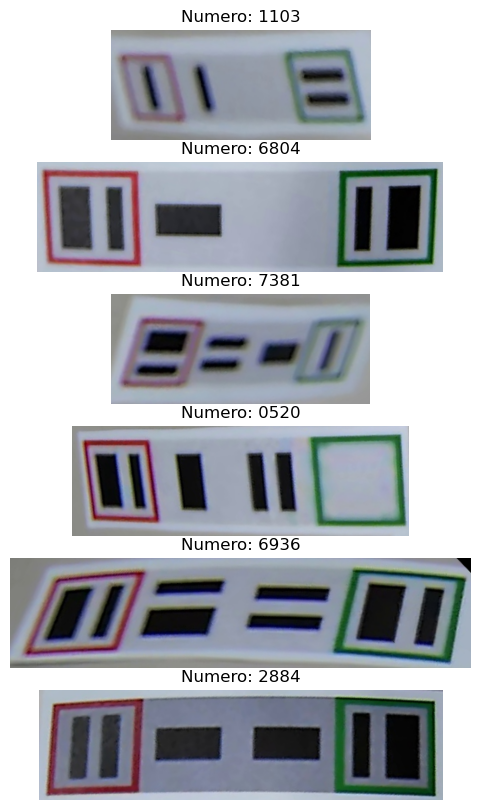

In [1631]:
plt.figure(figsize=[15, 10])
numbers = []
for i, img in enumerate(extracted_images):
    thresholded_image = threshold_image(img)
    contours = get_contours(thresholded_image, img)
    segment_info = get_segment_info(contours, img)
    segment_number = decode_number(segment_info)
    # Display the image and the segment number
    plt.subplot(len(extracted_images), 1, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Numero: {segment_number}')
    numbers.append(segment_number)
plt.show()
    

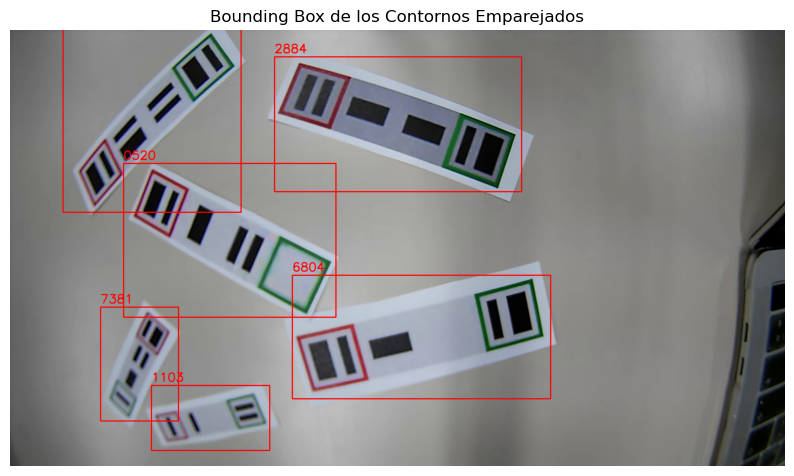

In [1632]:
# Dibujar la bounding box que contenga todos los puntos de los contornos emparejados
def dibujar_bounding_box(contornos_emparejados, imagen, numero):
    # Crear una copia de la imagen original para dibujar la bounding box
    imagen_con_bounding_box = np.copy(imagen)
    for i, (red_contour, green_contour) in enumerate(contornos_emparejados):
            # Obtener los puntos de los contornos
            red_points = np.array(red_contour['corners'])
            green_points = np.array(green_contour['corners'])

            # Combinar los puntos de ambos contornos
            all_points = np.vstack((red_points, green_points))

            # Calcular la bounding box que contenga todos los puntos
            x_min, y_min = np.min(all_points, axis=0)
            x_max, y_max = np.max(all_points, axis=0)

            # Dibujar la bounding box
            cv2.rectangle(imagen_con_bounding_box, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)
            # Dibujar el número
            cv2.putText(imagen_con_bounding_box, numero[i], (int(x_min), int(y_min - 10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)     
    return imagen_con_bounding_box

# Dibujar la bounding box
imagen_con_bounding_box = dibujar_bounding_box(matched_contours, image, numbers)

# Mostrar la imagen con la bounding box
plt.figure(figsize=[10, 10])
plt.imshow(imagen_con_bounding_box)
plt.axis('off')
plt.title('Bounding Box de los Contornos Emparejados')
plt.show()
